<a href="https://colab.research.google.com/github/tomifarall/Orga-Datos-Tp2/blob/master/featurehashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import nltk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from keras.layers import Dense, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [83]:
#ESTO NO LO EJECUTEN SI UTILIZAN UNA VERSION DE PC , YO LO HAGO PARA PODER USAR EL TRAIN DE MI DRIVE,Y USAR EL GITHUB ONLINE
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [84]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1RJH-BaqHHtZzrSgu6yUVc8bRXcfev9tB'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_1.csv')

In [85]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1sivn_RJ13uL13DmmB_G03yJRJWw_b2He'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_2.csv')

In [86]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1eO4Vnym1_XoOx8yL1UC9WmZJvROH4dt_'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_3.csv')


In [87]:

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '18Ab39T1hPgTBv58oXdVk0NfBE36Fp21D'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_3.csv')


In [88]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
test_id = '1uPd0roB5CyXnjXHm3R_0QqKcoaCZyrpX'
downloaded = drive.CreateFile({'id': test_id})
downloaded.GetContentFile('test_original.csv')

In [204]:
test_original=pd.read_csv('test_original.csv')

In [205]:
#train_1 = pd.read_csv('train_1.csv')
#train_2= pd.read_csv('train_2.csv')
train_3=pd.read_csv('train_3.csv')
test_3=pd.read_csv('test_3.csv')


In [206]:
#limpiando el texto

def clean_text(train):

  import nltk
  nltk.download('stopwords') 
  nltk.download('punkt')
  nltk.download('wordnet')
  from nltk.tokenize import word_tokenize
  from nltk.corpus import stopwords
  from nltk.stem.wordnet import WordNetLemmatizer

  #FUNCIONES UTILES

  def only_letters(tweet):
      tweet = re.sub(r'http\S*', '', tweet)
      tweet = re.sub(r'[^a-z\s]', '', tweet)
      return tweet

  stop_words=set(stopwords.words("english"))

  def filter_stopwords(tokenized_text):
      filtered_words=[]
      for w in tokenized_text:
          if w not in stop_words:
              filtered_words.append(w)
      return filtered_words

  lemmatizer = WordNetLemmatizer()

  def lemmatize_tweet(tweet):
      lemmatized_words = []
      for word in tweet:
          lemmatized_words.append(lemmatizer.lemmatize(word))
      return lemmatized_words

  def transform_to_text(tweet_words):
      return " ".join(tweet_words)

  #Cleaning text

  train['clean_text'] = train['text'].str.lower()

  train['clean_text'] = train['clean_text'].apply(only_letters)    

  #Tokenización

  train['clean_text'] = train['clean_text'].apply(word_tokenize)

  #Remove stopwords

  train['clean_text'] = train['clean_text'].apply(filter_stopwords) 

  #Lemmatization                                                                       

  train['clean_text'] = train['clean_text'].apply(lemmatize_tweet)  

  train['clean_text'] = train['clean_text'].apply(transform_to_text)

In [207]:
def feature_hashing(cant_column_original,cant_colum_reducir,matriz_original):

  import random
   
  a=[]
  filas=cant_column_original
  columnas=cant_colum_reducir
  for i in range(filas):
      binario=0
      second=0
      a.append([])
      for j in range(columnas):
          binario=random.randint(0,2)
          if( binario==1 and second==0):
            
            second=1
            a[i].append(1)
          elif(j==columnas-1 and second==0):
            a[i].append(1)
          else:  
            a[i].append(0)  

  B=list(a)

  result=matriz_original.dot(B)

  return result 

In [208]:
#hacerlo despues de agregar features, para setear las locaciones vacias con not_location
#locaciones con 1 o dos tweet, no aportan nada a la machine learning, mayores a 5 tomo minimo
def nombres_locaciones_mayor_frecuencia(train):
  filtro_cant_location=train.groupby('location').agg(cantidad_apariciones=('location','count'))
  nombres_locaciones_mayor_frecuencia=filtro_cant_location[filtro_cant_location['cantidad_apariciones']>5].index
  nombres_locaciones_mayor_frecuencia=list(nombres_locaciones_mayor_frecuencia)
  train_filtrado=train[train['location'].isin(nombres_locaciones_mayor_frecuencia)==True]
  return train_filtrado

In [209]:
#se hace afuera porque seteo con el fin las palabras de tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
corpus=train_3['clean_text']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
#feature_hashing# reducimos dimension de tf-idf por teorema de listruss johson

matriz_tfidf=X.toarray()
filas=matriz_tfidf.shape[0]
cant_column_original=matriz_tfidf.shape[1]
matriz_red=feature_hashing(cant_column_original,6,matriz_tfidf)

  #agregamos esas columnas a la matriz original
df = pd.DataFrame(matriz_red) 
train_3[list(df.columns)]=df

In [210]:
def feature_engi(train_3):
  train_tfidf=train_3

  #completo null
  train_tfidf['keyword'].fillna('no keyword', inplace = True)
  train_tfidf['location'].fillna('no location', inplace = True)
  #mean_encoding
  
    
  train_tfidf['mean_encoding_keyword']=train_tfidf.groupby('keyword')['target'].transform('mean')
  train_tfidf['mean_encoding_location']=train_tfidf.groupby('location')['target'].transform('mean')
    
   
  return train_tfidf





In [238]:
#location_dic posee location y mean_enconding
def feature_engi_test(test ):
  train_tfidf=test

  #completo null
  train_tfidf['keyword'].fillna('no keyword', inplace = True)
  train_tfidf['location'].fillna('no location', inplace = True)
  #mean_encoding
  
    
  train_tfidf['mean_encoding_location']= train_tfidf['location'].map(location_dict)
  train_tfidf['mean_encoding_keyword']= train_tfidf['keyword'].map(keyword_dict)
    
  #tf-idf

  
  corpus=train_tfidf['clean_text']
  #vectorizer = TfidfVectorizer() ya lo cargamos antes en el train
  X = vectorizer.transform(corpus)
  #print(vectorizer.get_feature_names())

  #feature_hashing# reducimos dimension de tf-idf por teorema de listruss johson

  matriz_tfidf=X.toarray()
  filas=matriz_tfidf.shape[0]
  cant_column_original=matriz_tfidf.shape[1]
  matriz_red=feature_hashing(cant_column_original,6,matriz_tfidf)

  #agregamos esas columnas a la matriz original
  df = pd.DataFrame(matriz_red) 
  train_tfidf[list(df.columns)]=df

  return train_tfidf

In [212]:
#cargamos las columnas entre otras coas
feature_train=feature_engi(train_3 )
feature_train_mas_frecuente=nombres_locaciones_mayor_frecuencia(feature_train)

In [213]:
feature_train_mas_frecuente.head(2)

,Unnamed: 0,id,keyword,location,text,target,clean_text,0,1,2,3,4,5,mean_encoding_keyword,mean_encoding_location
0,0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze,0.950988,0.425568,0.000000,0.000000,0.0,0.598773,0.361111,0.875000
2,2,50,ablaze,Africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...,0.775244,0.675258,0.471128,0.315971,0.0,0.368443,0.361111,0.540541


In [214]:
feature_train_mas_frecuente.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5055 entries, 0 to 7612
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              5055 non-null   int64  
 1   id                      5055 non-null   int64  
 2   keyword                 5055 non-null   object 
 3   location                5055 non-null   object 
 4   text                    5055 non-null   object 
 5   target                  5055 non-null   int64  
 6   clean_text              5055 non-null   object 
 7   0                       5055 non-null   float64
 8   1                       5055 non-null   float64
 9   2                       5055 non-null   float64
 10  3                       5055 non-null   float64
 11  4                       5055 non-null   float64
 12  5                       5055 non-null   float64
 13  mean_encoding_keyword   5055 non-null   float64
 14  mean_encoding_location  5055 non-null   

# agrego columnas del test

In [245]:
#las locaciones con mean_coding_location lo saco del train
location_dict = pd.Series(feature_train_mas_frecuente['mean_encoding_location'].values, index=feature_train_mas_frecuente['location']).to_dict()
#completo con mean_encoding_keyword
keyword_dict = pd.Series(feature_train_mas_frecuente['mean_encoding_keyword'].values, index=feature_train_mas_frecuente['keyword']).to_dict()

In [246]:
test_3=pd.read_csv('test_3.csv')

In [247]:
clean_text(test_3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [248]:
test_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3263 non-null   int64 
 1   id          3263 non-null   int64 
 2   keyword     3237 non-null   object
 3   location    2383 non-null   object
 4   text        3263 non-null   object
 5   clean_text  3263 non-null   object
dtypes: int64(2), object(4)
memory usage: 153.1+ KB


In [249]:
test_with_feature=feature_engi_test(test_3)
#relleno con 0 los que estan con nan los mean_encoding_location
test_with_feature['mean_encoding_location']=test_with_feature['mean_encoding_location'].fillna(0)
test_with_feature['mean_encoding_keyword']=test_with_feature['mean_encoding_keyword'].fillna(0)

In [253]:
test_with_feature.head(2)

,Unnamed: 0,id,keyword,location,text,clean_text,mean_encoding_location,mean_encoding_keyword,0,1,2,3,4,5
0,0,46,ablaze,Florida,Birmingham Wholesale Market is ablaze BBC News...,birmingham wholesale market ablaze bbc news fi...,0.369099,0.361111,1.438384,0.000000,0.551671,0.155011,0.367398,0.0
1,1,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...,sunkxssedharry wear short race ablaze,0.000000,0.361111,0.971551,0.475949,0.543090,0.000000,0.000000,0.0


In [259]:
def remove_unused_columns(data): 
  train_tfidf=data
  train_tfidf=train_tfidf.drop( columns='Unnamed: 0')
  train_tfidf=train_tfidf.drop( columns='keyword')
  train_tfidf=train_tfidf.drop( columns='location')
  train_tfidf=train_tfidf.drop( columns='clean_text')
  train_tfidf=train_tfidf.drop( columns='text')
  train_tfidf=train_tfidf.drop( columns='id')
  return train_tfidf

In [257]:
train_formateado=remove_unused_columns_train(feature_train_mas_frecuente)
train_formateado.head(2)

,target,0,1,2,3,4,5,mean_encoding_keyword,mean_encoding_location
0,1,0.950988,0.425568,0.000000,0.000000,0.0,0.598773,0.361111,0.875000
2,1,0.775244,0.675258,0.471128,0.315971,0.0,0.368443,0.361111,0.540541


In [ ]:
#quito columnas inneesario de test

In [263]:
test_formateado=remove_unused_columns(test_with_feature)
test_formateado.head(2)

,mean_encoding_location,mean_encoding_keyword,0,1,2,3,4,5
0,0.369099,0.361111,1.438384,0.000000,0.551671,0.155011,0.367398,0.0
1,0.000000,0.361111,0.971551,0.475949,0.543090,0.000000,0.000000,0.0


In [265]:
#separao target del train
target=train_formateado['target']
train_formateado=train_formateado.drop( columns='target')



KeyError: ignored

In [266]:
train_formateado.head(1)

,0,1,2,3,4,5,mean_encoding_keyword,mean_encoding_location
0,0.950988,0.425568,0.0,0.0,0.0,0.598773,0.361111,0.875


In [332]:
#el test no se separa el target porque no tiene XD JA
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [269]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

In [270]:
X= train_formateado
y = target.values

In [271]:
len(train_formateado.columns)

8

In [272]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5055 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   0                       5055 non-null   float64
 1   1                       5055 non-null   float64
 2   2                       5055 non-null   float64
 3   3                       5055 non-null   float64
 4   4                       5055 non-null   float64
 5   5                       5055 non-null   float64
 6   mean_encoding_keyword   5055 non-null   float64
 7   mean_encoding_location  5055 non-null   float64
dtypes: float64(8)
memory usage: 355.4 KB


In [401]:
model=LogisticRegression(class_weight='balanced')
print(cross_val_score(model, X, y, cv=9,scoring='f1'))

[0.75968992 0.72762646 0.73513514 0.74242424 0.7412844  0.80160321
 0.65800866 0.70541082 0.77244259]


In [402]:
#Set train
y_pred_log = cross_val_predict(model, X, y, cv=9)
f1score = f1_score(target, y_pred_log)
print(f'Counts model score: {f1score*100}%')



Counts model score: 73.87426582553839%


In [279]:
#Xgboost
import xgboost as xgb


In [280]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
#xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
#                colsample_bytree = 0.3, learning_rate = 0.03,
#                max_depth = 40, alpha = 10, n_estimators = 1000)
0.39
#xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
#                colsample_bytree = 0.3, learning_rate = 0.03,
#                max_depth = 15, alpha = 10, n_estimators = 1000)
0.37

In [325]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 13, alpha = 10, n_estimators = 30000)

In [326]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=None, n_estimators=30000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [327]:
preds = xg_reg.predict(X_test)

In [328]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.431452


con crossvalidation

In [350]:
data_dmatrix = xgb.DMatrix(data=train_formateado,label=target)

In [393]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.01,
          'learning_rate': 0.3, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=8,
                    num_boost_round=60, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)

In [394]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.495300,0.000227,0.496773,0.001290
1,0.454925,0.027005,0.458961,0.026127
2,0.445538,0.021478,0.450352,0.021788
3,0.443737,0.021780,0.449511,0.021861
4,0.438440,0.024969,0.445854,0.024213


In [395]:
print((cv_results["test-rmse-mean"]).tail(1))

41    0.408464
Name: test-rmse-mean, dtype: float64


vamos a usar tecnicas de balanceo 

In [348]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    print(cross_val_score(clf, X, y, cv=80,scoring='f1'))
    
    return clf
 
model = run_model_balanced(X_train, X_test, y_train, y_test)

[0.73846154 0.58333333 0.78125    0.71428571 1.         0.88461538
 0.86206897 0.58461538 0.66666667 0.6984127  0.42553191 0.93333333
 0.66666667 0.87096774 0.77966102 0.65714286 0.77192982 0.78873239
 0.6031746  0.8        0.7037037  0.8358209  0.64102564 0.8125
 0.86153846 0.57142857 0.82758621 0.68181818 0.68965517 0.72222222
 0.63157895 0.81355932 0.77192982 0.64285714 0.76923077 0.84
 0.74285714 0.56603774 0.81481481 0.61016949 0.73846154 0.82539683
 0.76056338 0.74576271 0.94545455 0.76470588 0.80851064 0.88
 0.96296296 0.8115942  0.76363636 0.78571429 0.55813953 0.83636364
 0.70833333 0.83636364 0.63414634 0.65384615 0.77777778 0.33962264
 0.70175439 0.4137931  0.82142857 0.69565217 0.38596491 0.73239437
 0.84615385 0.60869565 0.85185185 0.84       0.6        0.70588235
 0.75       1.         0.72413793 0.70175439 0.6122449  0.7826087
 0.78571429 0.85714286]


In [338]:
print(cross_val_score(model, X, y, cv=80,scoring='f1'))

[0.73846154 0.58333333 0.78125    0.71428571 1.         0.88461538
 0.86206897 0.58461538 0.66666667 0.6984127  0.42553191 0.93333333
 0.66666667 0.87096774 0.77966102 0.65714286 0.77192982 0.78873239
 0.6031746  0.8        0.7037037  0.8358209  0.64102564 0.8125
 0.86153846 0.57142857 0.82758621 0.68181818 0.68965517 0.72222222
 0.63157895 0.81355932 0.77192982 0.64285714 0.76923077 0.84
 0.74285714 0.56603774 0.81481481 0.61016949 0.73846154 0.82539683
 0.76056338 0.74576271 0.94545455 0.76470588 0.80851064 0.88
 0.96296296 0.8115942  0.76363636 0.78571429 0.55813953 0.83636364
 0.70833333 0.83636364 0.63414634 0.65384615 0.77777778 0.33962264
 0.70175439 0.4137931  0.82142857 0.69565217 0.38596491 0.73239437
 0.84615385 0.60869565 0.85185185 0.84       0.6        0.70588235
 0.75       1.         0.72413793 0.70175439 0.6122449  0.7826087
 0.78571429 0.85714286]


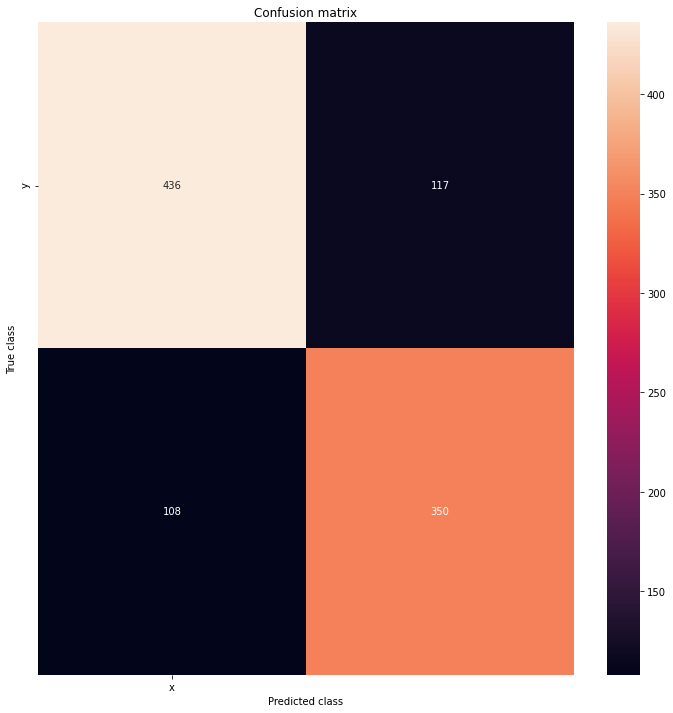

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       553
           1       0.75      0.76      0.76       458

    accuracy                           0.78      1011
   macro avg       0.78      0.78      0.78      1011
weighted avg       0.78      0.78      0.78      1011



In [349]:
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels='x', yticklabels='y', annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))
 
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [331]:
target.value_counts()

0    2799
1    2256
Name: target, dtype: int64

In [ ]:
train_tfidf RMSE: 0.375965

In [ ]:
tweets_test=test_3

In [ ]:
#tweets['clean_text'] = tweets['text'].str.lower()
tweets_test['clean_text'] = tweets_test['text'].str.lower()

def only_letters(tweet):
    tweet = re.sub(r'http\S*', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return tweet

tweets_test['clean_text'] = tweets_test['clean_text'].apply(only_letters)    

import nltk
nltk.download('stopwords') 
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#tweets['clean_text'] = tweets['clean_text'].apply(word_tokenize)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(word_tokenize)
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))


#Elimino stopwords
def filter_stopwords(tokenized_text):
    not_stopwords=[]
    for w in tokenized_text:
        if w not in stop_words:
            not_stopwords.append(w)
    return not_stopwords


tweets_test['clean_text'] = tweets_test['clean_text'].apply(filter_stopwords)    

#Lematización
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_tweet(tweet):
    lemmatized_words = []
    for word in tweet:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

tweets_test['clean_text'] = tweets_test['clean_text'].apply(lemmatize_tweet)


In [ ]:
#tweets['clean_text'] = tweets['text'].str.lower()
tweets_test['clean_text'] = tweets_test['text'].str.lower()

In [ ]:
def only_letters(tweet):
    tweet = re.sub(r'http\S*', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return tweet

In [ ]:
tweets_test['clean_text'] = tweets_test['clean_text'].apply(only_letters)

In [ ]:

import nltk
nltk.download('stopwords') 
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#tweets['clean_text'] = tweets['clean_text'].apply(word_tokenize)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(word_tokenize)
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Elimino stopwords
def filter_stopwords(tokenized_text):
    not_stopwords=[]
    for w in tokenized_text:
        if w not in stop_words:
            not_stopwords.append(w)
    return not_stopwords

In [ ]:
tweets_test['clean_text'] = tweets_test['clean_text'].apply(filter_stopwords)

In [ ]:
#Lematización
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize_tweet(tweet):
    lemmatized_words = []
    for word in tweet:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

In [ ]:
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lemmatize_tweet)

In [ ]:
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lambda text:' '.join(text))

In [ ]:
def find_url(text):
    urls = re.findall(r'(https?://\S+)', text)
    return urls

In [ ]:
tweets_test['urls']=tweets_test['text'].apply(find_url)

In [ ]:
def add_url_to_text(clean_text, urls):
    if urls:
        for url in urls:
            url_split = url.split('/')
            return (' '.join([clean_text,url_split[0][:-1],url_split[2]]))
    else:
        return clean_text

In [ ]:
tweets_test['clean_text'] = tweets_test.apply(lambda tweet: add_url_to_text(tweet['clean_text'],tweet['urls']),axis=1)

In [ ]:
def formar_csv:
    #Set de validación
  preds = model.predict(X_test)
  preds = preds >= 0.5
  preds
  #sumision=pd.DataFrame( 1 if (preds==True) elif 0)
  submission=pd.DataFrame( preds.astype(int) )
  submission.columns=['target']
  submission['id']=test_3['id']
  df=submission[['id','target']]
  from google.colab import files
  df.to_csv('datacnn.csv',header=True,index=False) 
  files.download('datacnn.csv')

In [ ]:



f1score = f1_score(y_test, preds)
print(f'F1 score: {f1score}')

In [ ]:
##start

In [ ]:
clean_text = tweets['clean_text'].values
labels = tweets['target'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_text, labels, test_size=0.20, random_state=15)


In [ ]:
X_set_test = tweets_test['clean_text'].values
 

In [ ]:
#Tokenizador
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# A secuencia de enteros
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [ ]:
X_set_test = tokenizer.texts_to_sequences(X_set_test)

In [ ]:
# Padding al final
maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
X_set_test = pad_sequences(X_set_test, padding='post', maxlen=maxlen)

In [ ]:
# # Se carga la matriz de embeddings
# embeddings_index = dict()
# f = open('glove.twitter.27B.100d.txt', encoding="utf8")
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
# # Matriz de embedding con palabras del set de train
# embedding_matrix = np.zeros((vocab_size, 100))
# for word, i in tokenizer.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

In [ ]:
!pip install gensim
from gensim.models import KeyedVectors
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above


--2020-07-29 19:33:43--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.86.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.86.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  24.9MB/s    in 26s     

2020-07-29 19:34:09 (61.5 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
word_vectors=word2vec

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        continue

    
del(word_vectors)

CNN

In [ ]:
X_train.shape

(6090, 20)

In [ ]:
input_shape = (X_train.shape[0],X_train.shape[1])
model = Sequential()

embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(512, 2, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 300)           5857200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 512)           307712    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 6,165,425
Trainable params: 308,225
Non-trainable params: 5,857,200
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=3, verbose=1, validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

Train on 4872 samples, validate on 1218 samples
Epoch 1/3
4872/4872 [==============================] - 3s 708us/step - loss: 0.4932 - accuracy: 0.7736 - val_loss: 0.4499 - val_accuracy: 0.8079
Epoch 2/3
4872/4872 [==============================] - 3s 696us/step - loss: 0.3747 - accuracy: 0.8450 - val_loss: 0.4247 - val_accuracy: 0.8186
Epoch 3/3
1523/1523 [==============================] - 0s 280us/step


In [ ]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.44108236546353613
Accuracy: 0.7957977652549744


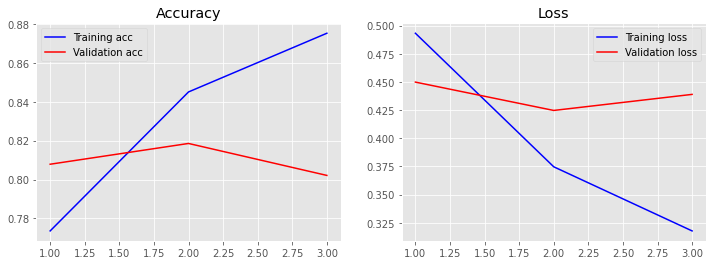

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()

plot_history(history)

In [ ]:
#Set de validación
preds = model.predict(X_test)
preds = preds >= 0.5
preds

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
def formar_csv:
    #Set de validación
  preds = model.predict(X_test)
  preds = preds >= 0.5
  preds
  sumision=pd.DataFrame( 1 if (preds==True) elif 0)
  submission=pd.DataFrame( preds.astype(int) )
  submission.columns=['target']
  submission['id']=test_3['id']
  df=submission[['id','target']]
  from google.colab import files
  df.to_csv('datacnn.csv',header=True,index=False) 
  files.download('datacnn.csv')


f1score = f1_score(y_test, preds)
print(f'F1 score: {f1score}')

In [ ]:
f1score = f1_score(y_test, preds)
print(f'F1 score: {f1score}')

F1 score: 0.7638572513287774


In [ ]:
sumision=pd.DataFrame( 1 if (preds==True) elif 0)

SyntaxError: ignored

In [ ]:
submission=pd.DataFrame( preds.astype(int) )
submission.columns=['target']

In [ ]:
len(submission)

3263

In [ ]:
submission['id']=test_3['id']

In [ ]:
df=submission[['id','target']]
df.shape

(3263, 2)

In [ ]:
from google.colab import files
df.to_csv('datacnn.csv',header=True,index=False) 
files.download('datacnn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission['id'] = tweets_test['id']

In [ ]:
submission=submission[['id','target']]

In [ ]:
submission.head(4)

,id,target
0,46,0
1,47,1
2,51,0
3,58,0


In [ ]:
from google.colab import files
submission.to_csv('datacnn.csv',header=True,index=False) 
files.download('datacnn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission.count()

id        1523
target    1523
dtype: int64

In [ ]:
submission.to_csv(path_or_buf='submissionxgb.csv',header=True,index=False)

In [ ]:
#Set de test
preds = model.predict(X_set_test)
preds = (preds >= 0.5).astype(int)
preds

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
len(preds)

3263

In [ ]:
preds.shape

(3263, 1)

In [ ]:
tweets_test['target'] = preds
submission = tweets_test.loc[:,['id','target']]
submission.to_csv(path_or_buf='submissioncnnw2v.csv',header=True,index=False)

In [ ]:
len(submission)

1523

In [ ]:
#Promedio
preds_xgb = pd.read_csv('submissionxgb.csv')['target']
preds_tfidf = pd.read_csv('submission.csv')['target']

In [ ]:
avg = (tweets_test['target'] + preds_tfidf + preds_xgb)/3
avg = (avg > 0.5).astype(int)

In [ ]:
tweets_test['target'] = avg
submission = tweets_test.loc[:,['id','target']]
submission.to_csv(path_or_buf='submissionavgcnnw2vtfidfxgb.csv',header=True,index=False)